In [1]:
%matplotlib inline

from collections import defaultdict
import random 
from typing import List, Optional, Tuple, Union

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tqdm 

In [2]:
class State:
    SUM = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
    CARDS = ['Ace', 2, 3, 4, 5, 6, 7, 8, 9, 10]
    CARDS_ = CARDS + [10, 10, 10]

    @staticmethod
    def n_states():
        return len(State.SUM) * len(State.CARDS)
    
    @staticmethod
    def id_to_state(index: int):
        id1 = index // 10
        id2 = index % 10
        return State.SUM[id1], State.CARDS[id2]
    
    @staticmethod
    def state_to_id(state: Tuple[int, Union[int, int]]):
        id1 = State.SUM.index(state[0])
        id2 = State.CARDS.index(state[1])
        return id1 * 10 + id2

In [3]:
class Environment:
    HIT_ACTION = 0
    STICK_ACTION = 1
    ACTIONS = (HIT_ACTION, STICK_ACTION)
    
    # current_state, action -> next_state, potential return if game is over
    def do_action(self, state_id, action) -> Tuple[Optional[State], Optional[int]]:
        state = State.id_to_state(state_id)
        if action == self.HIT_ACTION:
            new_card = self._draw_card()
            new_sum = self._get_new_sum(state[0], new_card)
            if new_sum > 21:
                return None, -1
            
            return State.state_to_id((new_sum, state[1])), None
        
        elif action == self.STICK_ACTION:
            dealer_sum = state[1] if state[1] != 'Ace' else 11
            blackjack = state[0] == 21
            while dealer_sum < 17:
                dealer_sum = self._get_new_sum(dealer_sum, self._draw_card())
                if dealer_sum != 21 and blackjack:
                    return None, 1
                
            if dealer_sum > 21:
                return None, 1

            if state[0] == dealer_sum:
                return None, 0
            elif state[0] > dealer_sum:
                return None, 1 
            else:
                return None, -1 
            
    def _draw_card(self) -> Union[int, str]:
        return random.choice(State.CARDS_)
            
    def _get_new_sum(self, current_sum, card) -> int:
        if card == 'Ace':
            if current_sum + 11 <= 21:
                return current_sum + 11
            else:
                return current_sum + 1
        return current_sum + card 

    def generate_random_state(self) -> int:
        return np.random.choice(np.arange(State.n_states()))
    
    def num_actions(self) -> int:
        return len(self.ACTIONS)
    
    def num_states(self) -> int:
        return State.n_states()

In [4]:
def run_episode(
    env: Environment,
    policy: np.ndarray
) -> Tuple[List[Tuple[int, int]], int]:
    
    episode_finished = False
    state_id = env.generate_random_state()
    trajectory = []
    
    while True:
        action = policy[state_id]
        next_state_id, r = env.do_action(state_id, action)
        trajectory.append((state_id, action))
        
        if r is not None:
            return trajectory, r

In [5]:
# first-visit monte-carlo prediction
def mc_prediction(
    env: Environment,
    policy: np.ndarray,
    n_iter: int,
) -> np.ndarray:
    
    value_function = np.ndarray(env.num_states())
    returns = np.zeros(env.num_states())
    counts = np.zeros(env.num_states())
    
    for i in tqdm.tqdm(range(n_iter)):
        trajectory, r = run_episode(env, policy)
        visited_states = set([x[0] for x in trajectory])
        for state_id in visited_states:
            counts[state_id] += 1
            returns[state_id] += r
    
    return returns / np.where(counts == 0, 1, counts)

In [6]:
def plot_value_function3d(value_function: np.ndarray):
    
    x, y = np.meshgrid([11 if c == 'Ace' else c for c in State.CARDS], State.SUM)
    z = np.zeros_like(x)
    for i in range(len(State.SUM)):
        for j in range(len(State.CARDS)):
            c = 'Ace' if x[i, j] == 11 else x[i, j]
            state_id = State.state_to_id((y[i, j], c))
            z[i, j] = value_function[state_id] 

            
    fig = plt.figure(figsize=(10, 6))
    ax = fig.gca(projection='3d')
    plt.xlabel("delear's card")
    plt.ylabel('player sum')
    surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False);

In [7]:
def plot_value_function2d(value_function: np.ndarray):
    x = []
    y = []
    for i in range(State.n_states()):
        s, c = State.id_to_state(i)
        x.append(11 if c == 'Ace' else c)
        y.append(s)
    fig, _ = plt.subplots(figsize=(10, 5)) 
    
    cmap = sns.cubehelix_palette(as_cmap=True)
    points = plt.scatter(x, y, c=value_function, cmap=cmap)
    fig.colorbar(points)
    plt.xlabel("delear's card")
    plt.ylabel('player sum');

In [8]:
policy = np.zeros(100)
for i in range(100):
    s, _ = State.id_to_state(i)
    if s >= 20:
        policy[i] = Environment.STICK_ACTION
    else:
        policy[i] = Environment.HIT_ACTION

In [9]:
env = Environment()

In [10]:
value_function = mc_prediction(env, policy, 10000)

100%|██████████| 10000/10000 [00:00<00:00, 60885.67it/s]


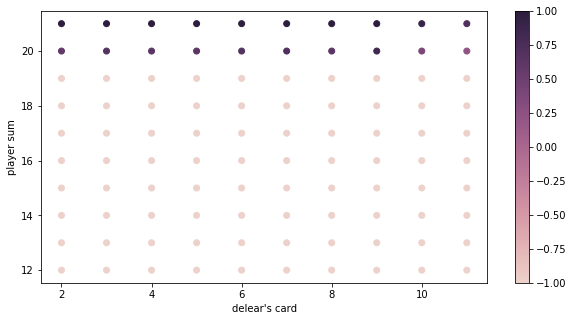

In [11]:
plot_value_function2d(value_function)

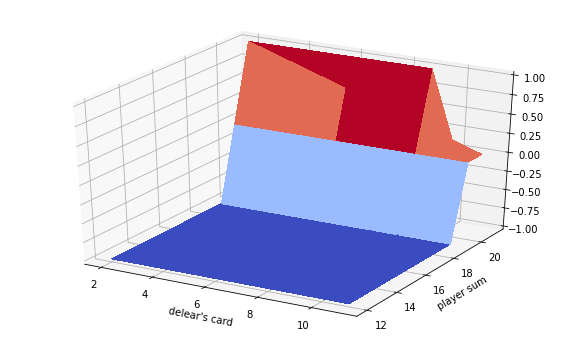

In [12]:
plot_value_function3d(value_function)

In [13]:
value_function = mc_prediction(env, policy, 500000)

100%|██████████| 500000/500000 [00:06<00:00, 73727.99it/s]


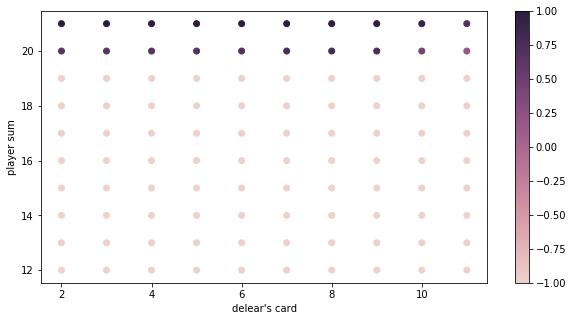

In [14]:
plot_value_function2d(value_function)

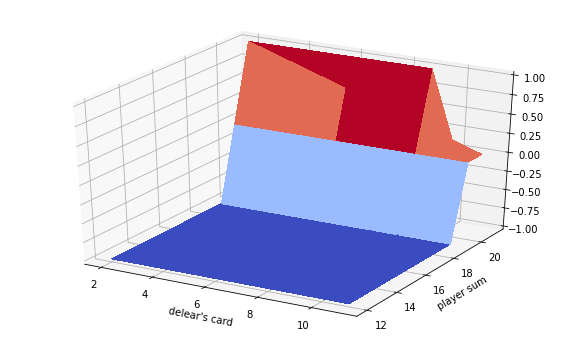

In [15]:
plot_value_function3d(value_function)